# Binospec Pointing Run  2020/07/08

On the night of July 8, 2020, a pointing run was carried out using Binospec's Single-Object Guider. This is the most convenient way to acquire pointing data with the f/5 configuration. It places an imaging camera at the center-of-rotation of the f/5 field-of-view with no extra re-imaging optics or mechanical stages. The pointing data was acquired while keeping the hexapod platform coordinates fixed. Pointing corrections due to tube flexure are performed using the hexapod to help maintain alignment between the optical axes of M1 and M2. The goal here was to measure the flexure using the mount and then use that to update the pointing models for both the mount and hexapod. 

Pointing data acquired with the mount is analyzed using [`tpoint`](http://www.tpointsw.uk/tpoint.htm) and `tpoint` models are implemented directly in the mount software. The MMTO's licensed copy of `tpoint` has been packaged into a Docker container so that it can be run on any platform Docker supports with no other dependencies. Information on how this container is built and run can be found at [https://github.com/MMTObservatory/tpoint_docker](https://github.com/MMTObservatory/tpoint_docker).

The MMTO's mount software implements the standard `tpoint` terms for alt-azimuth telescopes plus two tube flexure terms. The implemented terms are as follows:

| Term    |                 Description                |             Formulae                 |
|:--      |:-------------------------------------------|------------------------------------:|
|  `IA`   | Zero-point offset in azimuth               | $\Delta A = -\mathtt{IA}$           |
|  `IE`   | Zero-point offset in elevation             | $\Delta E = +\mathtt{IE}$           |
| `NPAE`  | Az/El non-perpindicularity                 | $\Delta A \simeq -\mathtt{NPAE} \tan(E)$ |
|  `CA`   | Non-perpindicularity between pointing direction and elevation axis | $\Delta A \simeq -\mathtt{CA} \sec(E)$ |
|  `AN`   | North-south misalignment of azimuth axis   | $\Delta A \simeq -\mathtt{AN} \sin(A) \tan(E)$; $\Delta E \simeq -\mathtt{AN} \cos(A)$ |
|  `AW`   | East-west misalignment of azimuth axis     | $\Delta A \simeq -\mathtt{AW} \cos(A) \tan(E)$; $\Delta E \simeq +\mathtt{AW} \sin(A)$ |
|  `TF`   | Classical tube flexure proportional to $\cos(E)$ | $\Delta E \simeq -\mathtt{TF} \cos(E)$ |
|  `TX`   | Empirical tube flexure proportional to $\frac{1}{\tan(E)}$ | $\Delta E \simeq \frac{-\mathtt{TX}}{\tan(E)}$ |


The current pointing model in the mount is based on pointing data taken with f/9 on 5/21/2007:
```
      1     IA         -0.026  +1191.16    1.289
      2     IE         -0.385     -1.81    0.304
      3     NPAE       -0.060     -4.23    1.533
      4     CA         +0.049    +16.71    1.878
      5     AN         +0.019     -1.32    0.103
      6     AW         +0.002    -13.25    0.103
      7     TF         +3.111     +7.65    0.889
      8     TX         -0.829     -2.80    0.291
            Sky RMS =   1.15
            Popn SD =   1.18
```
The `TF` term is actually set to 0 within the mount software since it was expected to be handled by the secondary mirror's hexapod and calibrated with different data, so-called "elcoll" runs. However, the `TX` term is *not* set to 0 within the mount and it should be. This is the first thing we should fix, though fortunately the effect isn't too large at the elevations we observe at.

A total of 73 pointing measurements were collected on 2020-07-08. Fitting the 8-term model to whole data set yields:
```
       coeff       change     value    sigma

  1     IA      +1206.365  +1206.37    6.235
  2     IE        -52.138    -52.14    1.503
  3     NPAE       -1.433     -1.43    6.370
  4     CA         +4.220     +4.22    8.486
  5     AN         +2.093     +2.09    0.373
  6     AW        -12.632    -12.63    0.365
  7     TF        -46.121    -46.12    3.566
  8     TX         -2.970     -2.97    0.950

Sky RMS =   2.71
Popn SD =   2.87
```

However, a significant part of the sky RMS comes from 3 outlier points with residuals of >6". Masking those data points out and re-doing the fit yields:
```
       coeff       change     value    sigma

  1     IA         -0.363  +1206.00    3.302
  2     IE         +0.420    -51.72    0.790
  3     NPAE       -0.728     -2.16    3.366
  4     CA         +0.589     +4.81    4.485
  5     AN         +0.284     +2.38    0.196
  6     AW         +0.271    -12.36    0.193
  7     TF         +6.064    -40.06    1.889
  8     TX         -1.580     -4.55    0.502

Sky RMS =   1.41
Popn SD =   1.50
```

The residuals to this fit show some small cyclical behavior as a function of azimuth. Taking the fit further by adding a harmonic term proportional to $\sin(A)$, `HESA`, and then masking the two points with residuals >2" yields:
```
       coeff       change     value    sigma

  1     IA         -0.692  +1205.27    1.799
  2     IE         +0.899    -50.82    0.433
  3     NPAE       -0.614     -2.80    1.826
  4     CA         +0.842     +5.71    2.436
  5     AN         +0.178     +2.55    0.107
  6     AW         -0.053    -12.58    0.181
  7     TF         +2.719    -37.32    1.044
  8     TX         -0.600     -5.16    0.275
  9     HESA       +0.408     +0.66    0.224

Sky RMS =   0.76
Popn SD =   0.82
```

A sky RMS of 0.76" over 68 stars is really very good! The harmonic component ends up being less than 1" in amplitude so we can lose it and re-do the 8-term fit over the 68 stars to get:
```
       coeff       change     value    sigma

  1     IA         -0.000  +1205.44    1.908
  2     IE         -0.000    -50.85    0.459
  3     NPAE       -0.000     -2.69    1.938
  4     CA         +0.000     +5.49    2.585
  5     AN         -0.000     +2.55    0.114
  6     AW         -0.000    -12.15    0.113
  7     TF         -0.000    -37.46    1.107
  8     TX         +0.000     -5.11    0.291

Sky RMS =   0.81
Popn SD =   0.86
```

Sub-arcsecond sky RMS for the standard 8-term model is as good as we've ever done at the MMTO. This shows that the mount is very capable of sub-arcsecond open-loop pointing accuracy. The remaining challenge is in getting the pointing models for the M2 hexapods to be similarly deterministic.

The largest changes with respect to the pointing model currently being used are in the encoder zero-points and in tube flexure. The later is expected because the new data was acquired with f/5 and M2 pointing disabled whereas the old data was acquired with f/9 and M2 pointng enabled. The changes in the zero-points are some cause for concern and may be indicative of a misalignment between the M1 and M2 optical axes. There are smaller changes in the axial alignment terms, but big enough to be noticeable. If the old alignment terms are used with the new data with tube flexure terms fixed to new values, these are the results:
```
       coeff       change     value    sigma

  1     IA        -13.888  +1191.56    0.768
  2     IE         -0.296    -51.15    0.534
  3     NPAE                  -4.23
  4     CA                   +16.71
  5     AN                    -1.32
  6     AW                   -13.25
  7     TF                   -37.46
  8     TX                    -5.11

Sky RMS =   4.41
Popn SD =   4.47
```
The zero-point terms had to be allowed to vary due to the 14" offset in azimuth. Allowing the tube flexure terms to vary does not change the results significantly, though. This shows that our current open-loop pointing performance is 4.4" RMS which is pretty far off from where we want to be. It also shows that the shifts in axial alignments within the mount since 2007 are significant and must be accounted for. Updating the mount software to use the new pointing model should yield immediate benefits and much improved pointing performance. 

There is still the question of optical alignment performance so let's look at what `tpoint` is measuring in terms of tube flexure and how it compares to the model we're currently using within the hexapod control software.

In [1]:
import matplotlib
from matplotlib import style
style.use('ggplot')
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

In [2]:
el = np.linspace(15, 90, 100) * u.deg

# for every arcsecond of M2 tilt, translate zc_trans microns to move M2 around zero-coma point
zc_trans = 9.453

# scale factor from arcsec of M2 zero-coma tilt to arcseconds on sky.
zc_sky = 0.3

In [3]:
# best fit tpoint model
ia = +1205.44
ie = -50.85
npae = -2.69
ca = 5.49
an = 2.55
aw = -12.15
tf = -37.46
tx = -5.11

In [4]:
# convert sky motion to ZC tilt
tiltx_cos_coeff = -1*tf / zc_sky
tiltx_tan_coeff = -1*tx / zc_sky

# calculate translations to go with the tilts
y_cos_coeff = zc_trans * tiltx_cos_coeff
y_tan_coeff = zc_trans * tiltx_tan_coeff
tiltx_cos_coeff, y_cos_coeff

(124.86666666666667, 1180.3646)

With the parameters set up, let's compare what our current hexapod pointing model is doing compared to what we have measured with `tpoint` with the hexapod platform fixed in place. The model within the hexapod control system is of the form $\Delta E = a \cos(E) + b \sin(E)$. Plus there is a `TX` term that is still currently implemented in the mount.

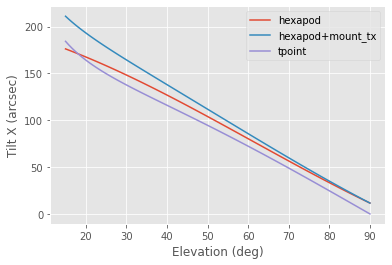

In [5]:
# the cos, sin, and zeropoint coeffs are taken from settings.xml; commanded tiltx from the logs
# the tpoint zeropoint is referenced to an elevation of 0, but the hexapod platform coordinates
# were set for an elevation around 40 deg. the difference between the commanded position and the
# configured zeropoint should account for this.
commanded = 355
zeropoint = 277.3
hex_pointing_offset = commanded - zeropoint
current_hexapod = 119.6*np.cos(el) - 66.1*np.sin(el) + hex_pointing_offset

# the cotangent coeff comes from the TX currently configured in the mount code. the tpoint coeff is in terms of
# zenith angle so flip the sign for elevation along with flipping tangent to cotangent.
current_tx = (2.8/zc_sky) * np.cos(el)/np.sin(el)

# combine hexapod and mount flexure terms
current_model = current_hexapod + current_tx

# use the tpoint coefficients scaled to hexapod motion
tpoint_model = tiltx_cos_coeff*np.cos(el) + tiltx_tan_coeff * np.cos(el)/np.sin(el)
plt.plot(el, current_hexapod, label="hexapod")
plt.plot(el, current_model, label="hexapod+mount_tx")
plt.plot(el, tpoint_model, label="tpoint")
plt.ylabel("Tilt X (arcsec)")
plt.xlabel("Elevation (deg)")
plt.legend()
plt.show()

This shows that our current open-loop flexure model is in good agreement with what was measured with the pointing run, certainly in a relative sense. The `TX` term in the mount is also shown to be a fairly small effect, alignment-wise. The difference is the equivalent to 10" of X tilt at an elevation of 30° and much less at higher elevations. 

Ideally, we will want to set `TX` to zero in the mount and handle everything flexure-related with the hexapod. We can implement the hexapod software's current flexure model in `tpoint` by replacing the `TF` and `TX` terms with `HESE` (harmonic elevation error proportional to $\sin(E)$) and `HECE` (harmonic elevation error proportional to $\cos(E)$). If we do this fit to the masked data from before, we get:
```
       coeff       change     value    sigma

  1     IA         +0.000  +1205.36    2.131
  2     IE         -0.002    -12.68    2.892
  3     NPAE       +0.000     -2.75    2.166
  4     CA         -0.000     +5.59    2.888
  5     AN         -0.000     +2.48    0.127
  6     AW         -0.000    -12.26    0.126
  7     HESE       -0.001    -33.08    2.169
  8     HECE       +0.004    +23.47    2.133

Sky RMS =   0.90
Popn SD =   0.96
```
The RMS of this fit is slightly worse than the `TF`/`TX` model, but still sub-arcsecond. Note also that the four axial misalignment terms are not significantly changed. Even leaving flexure completely out of the fitting gives the same results within the uncertainties for those terms:
```
       coeff       change     value    sigma

  1     IA         -0.007  +1205.11   27.176
  2     IE         -0.000    -19.84    1.401
  3     NPAE       -0.007     -2.96   27.617
  4     CA         +0.010     +5.92   36.826
  5     AN         -0.000     +2.64    1.616
  6     AW         -0.000    -12.63    1.600

Sky RMS =  11.49
Popn SD =  12.03
```

In [6]:
# define the tpoint harmonic parameters and scale them to hexapod tilts
hese = -33.08
hece = 23.47
tpoint_sin, tpoint_cos = hese/zc_sky, hece/zc_sky
print(tpoint_cos, tpoint_sin)

78.23333333333333 -110.26666666666667


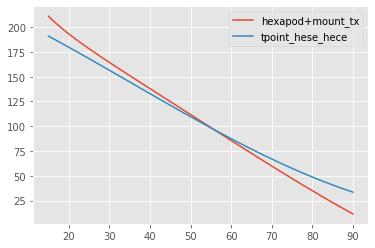

In [7]:
# bring the tpoint model onto the same zeropoint scale by taking out the IE term calculated by fitting with no flexure and
# including the extra offset in the hexapod platform to fix point to an elevation of 40 deg. we take IE out because the hexapod
# zeropoints are referenced to the current mount code's IE value of -1.81.
ie = -19.84
tpoint_hexapod = tpoint_sin * np.sin(el) + tpoint_cos * np.cos(el) - ie/zc_sky + hex_pointing_offset

plt.plot(el, current_model, label="hexapod+mount_tx")
plt.plot(el, tpoint_hexapod, label="tpoint_hese_hece")
plt.legend()
plt.show()

So the `tpoint` model using `HESE` and `HECE` tracks what we're currently doing reasonably well, but let's look at the residuals and see:

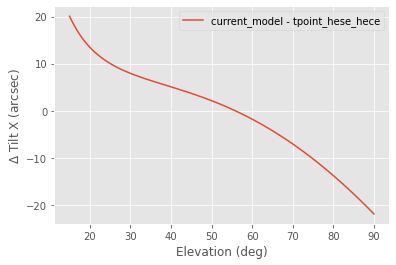

-0.4861847086510494


In [8]:
residuals = current_model - tpoint_hexapod
plt.plot(el, residuals, label="current_model - tpoint_hese_hece")
plt.ylabel("$\Delta$ Tilt X (arcsec)")
plt.xlabel("Elevation (deg)")
plt.legend()
plt.show()
print(np.mean(residuals))

So not so constant after all, but it's not clear what the provenance is for our current hexapod model or how well-determined it is. 

## Conclusions

The pointing data collected with Binospec on 2020/07/08 shows that the pointing model used by the MMT is clearly in need of improvement. The axial alignment terms have changed significantly from the ones currently implemented that were originally derived over 13 years ago. The currently implemented model has an RMS pointing accuracy of 4.5" with pointing error amplitudes approaching 10" in parts of the sky. Implementing a new model based on the new data promises to improve this to better than 1" RMS across the entire sky.

The flexure model we are currently using is working reasonably well, but this new data should provide some improvement. The `tpoint` `TX` term currently enabled in the mount should be disabled and the `HESE` and `HECE` terms measured by `tpoint` should be used to update the sin and cos coefficients in `settings.xml` for the `TILTX` and `Y` axes. The sin and cos coefficients for the `TILTY` and `X` axes should be set to 0. The side-to-side errors they were correcting are actually due to the axial misalignments in the mount and corrections for them should be handled there rather than in the hexapod.

An outstanding issue is that there is a degeneracy between the zeropoints in the hexapod and mount pointing models. This highlights the need to re-visit doing a "zero-order" pointing run using an alignment telescope mounted on the rotator at the center of rotation. This was last done